# **DSCI 552 Assignment 6**
#### ~ *Kanchi Tank (khtank@usc.edu)*
#### ~ *Snigdha Chenjeri (chenjeri@usc.edu)*
#### ~ *Karunya Munagala (kmunagal@usc.edu)*

In [1]:
import tensorflow as tf

In [2]:
# Check if a GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU available")
else:
    print("GPU not available")

# Create a TensorFlow session with GPU device placement
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU device:", gpus[0])
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found")

GPU available
Using GPU device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_fscore_support
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import Callback
from functools import partial

In [4]:
df = tf.keras.datasets.cifar10.load_data()

In [5]:
(X_train_full, y_train_full), (X_test, y_test) = df

In [6]:
# Split the data into training and validation sets
split_index = int(0.8 * len(X_train_full))
X_train, y_train = X_train_full[:split_index], y_train_full[:split_index]
X_valid, y_valid = X_train_full[split_index:], y_train_full[split_index:]

In [7]:
X_train.shape

(40000, 32, 32, 3)

In [8]:
y_train.shape

(40000, 1)

In [9]:
# Preprocess the data
X_train = X_train.astype('float32') / 255.0
X_valid = X_valid.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [10]:
X_train.shape

(40000, 32, 32, 3)

In [11]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_names[y_train[0][0]]

'frog'

## Convolutional Neural Network (without BatchNormalization)

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)          0

In [14]:
model.layers

In [15]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [16]:
class TimingCallback(Callback):
    def on_train_begin(self, logs={}):
        self.epoch_times_cpu = []
        self.epoch_times_wall = []
        
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_start_time_cpu = time.process_time()
        self.epoch_start_time_wall = time.time()
        
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_times_cpu.append(time.process_time() - self.epoch_start_time_cpu)
        self.epoch_times_wall.append(time.time() - self.epoch_start_time_wall)

In [17]:
time_callback_cnn = TimingCallback()

In [18]:
# Record start time and CPU time
start_time, start_cpu = time.time(), time.process_time()

# Fit the model with 30 epochs and record the training history
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks = [time_callback_cnn])

# Calculate CPU and wall time
cpu_time = time.process_time() - start_cpu
wall_time = time.time() - start_time

Epoch 1/100
1250/1250 [==============================] - 18s 8ms/step - loss: 1.6243 - accuracy: 0.4076 - val_loss: 1.3759 - val_accuracy: 0.5087
Epoch 2/100
1250/1250 [==============================] - 8s 7ms/step - loss: 1.2895 - accuracy: 0.5397 - val_loss: 1.1220 - val_accuracy: 0.6046
Epoch 3/100
1250/1250 [==============================] - 7s 6ms/step - loss: 1.1554 - accuracy: 0.5928 - val_loss: 1.0322 - val_accuracy: 0.6298
Epoch 4/100
1250/1250 [==============================] - 7s 6ms/step - loss: 1.0710 - accuracy: 0.6194 - val_loss: 0.9950 - val_accuracy: 0.6556
Epoch 5/100
1250/1250 [==============================] - 8s 7ms/step - loss: 1.0134 - accuracy: 0.6428 - val_loss: 0.9502 - val_accuracy: 0.6649
Epoch 6/100
1250/1250 [==============================] - 8s 6ms/step - loss: 0.9581 - accuracy: 0.6611 - val_loss: 0.9080 - val_accuracy: 0.6850
Epoch 7/100
1250/1250 [==============================] - 7s 5ms/step - loss: 0.9177 - accuracy: 0.6777 - val_loss: 0.9069 - val_a

In [19]:
# Print the CPU and Wall time for each epoch
for i in range(len(time_callback_cnn.epoch_times_cpu)):
    print("Epoch {} => CPU Time: {:.2f}s, Wall Time: {:.2f}s".format(i+1, time_callback_cnn.epoch_times_cpu[i], time_callback_cnn.epoch_times_wall[i]))

Epoch 1 => CPU Time: 6.53s, Wall Time: 18.43s
Epoch 2 => CPU Time: 1.73s, Wall Time: 8.18s
Epoch 3 => CPU Time: 1.77s, Wall Time: 7.15s
Epoch 4 => CPU Time: 1.34s, Wall Time: 7.34s
Epoch 5 => CPU Time: 1.67s, Wall Time: 8.24s
Epoch 6 => CPU Time: 1.62s, Wall Time: 7.83s
Epoch 7 => CPU Time: 1.36s, Wall Time: 6.59s
Epoch 8 => CPU Time: 1.31s, Wall Time: 6.31s
Epoch 9 => CPU Time: 1.09s, Wall Time: 6.41s
Epoch 10 => CPU Time: 1.23s, Wall Time: 6.25s
Epoch 11 => CPU Time: 1.44s, Wall Time: 6.37s
Epoch 12 => CPU Time: 1.23s, Wall Time: 6.34s
Epoch 13 => CPU Time: 1.23s, Wall Time: 6.38s
Epoch 14 => CPU Time: 1.31s, Wall Time: 6.36s
Epoch 15 => CPU Time: 1.00s, Wall Time: 6.40s
Epoch 16 => CPU Time: 1.75s, Wall Time: 7.75s
Epoch 17 => CPU Time: 1.50s, Wall Time: 6.39s
Epoch 18 => CPU Time: 1.69s, Wall Time: 6.43s
Epoch 19 => CPU Time: 0.94s, Wall Time: 6.46s
Epoch 20 => CPU Time: 0.78s, Wall Time: 6.38s
Epoch 21 => CPU Time: 1.05s, Wall Time: 6.43s
Epoch 22 => CPU Time: 1.16s, Wall Time: 6.

In [20]:
# Print the total CPU and wall time
print("CPU time:", cpu_time)
print("Wall time:", wall_time)

CPU time: 98.140625
Wall time: 1066.862412929535


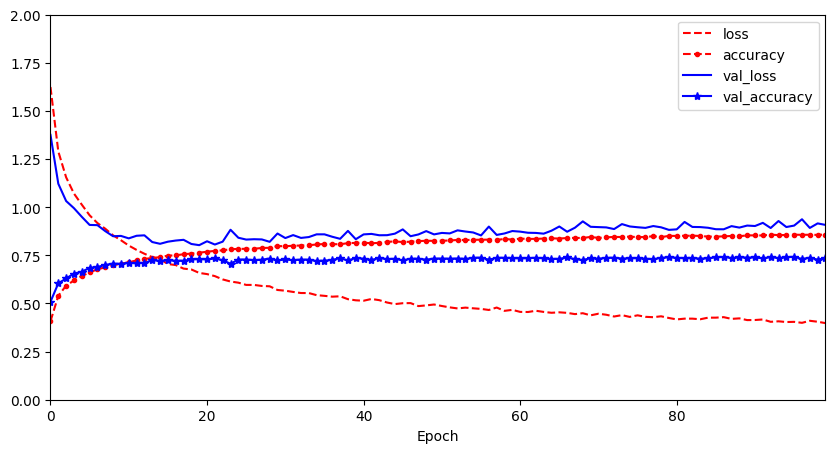

In [21]:
# Plot loss and accuracy versus epoch
pd.DataFrame(history.history).plot(figsize=(10, 5), xlim=[0, 99], ylim=[0, 2], grid=False, xlabel="Epoch", style=["r--", "r--.", "b-", "b-*"])
plt.show()

In [22]:
test_loss, test_acc = model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.8953 - accuracy: 0.7306


In [ ]:
y_proba = model.predict(X_test)
y_proba.round(2)

313/313 [==============================] - 1s 2ms/step


array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 1.  , 0.  ],
       [0.01, 0.42, 0.  , ..., 0.  , 0.49, 0.08],
       ...,
       [0.  , 0.  , 0.03, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.01, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 1.  , 0.  , 0.  ]], dtype=float32)

In [ ]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([3, 8, 8, ..., 5, 4, 7], dtype=int64)

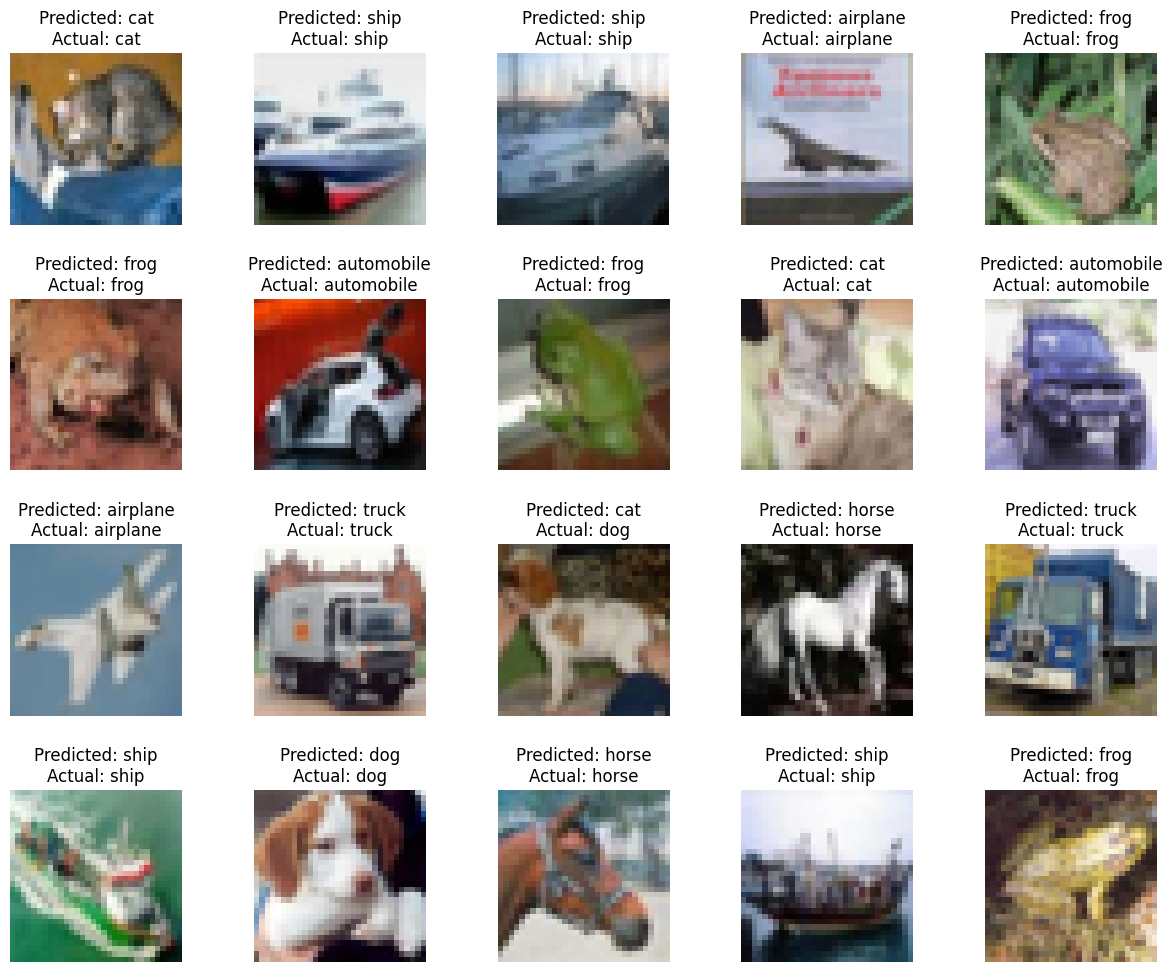

In [ ]:
# Print images and predicted labels
num_images = 20
plt.figure(figsize=(15, 15))
for i in range(num_images):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_test[i])
    predicted_label = class_names[y_pred[i]]
    actual_label = class_names[y_test[i][0]]
    plt.title("Predicted: {}\nActual: {}".format(predicted_label, actual_label))
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=0.43)
plt.show()

In [ ]:
# Calculate the accuracy, precision, and recall for the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

# Convert the scores to percentages
accuracy_pct = accuracy * 100
precision_pct = precision * 100
recall_pct = recall * 100

# Print the accuracy, precision, and recall for the test set as percentages
print("Test accuracy: {:.2f}%".format(accuracy_pct))
print("Test precision: {:.2f}%".format(precision_pct))
print("Test recall: {:.2f}%".format(recall_pct))

Test accuracy: 73.06%
Test precision: 73.55%
Test recall: 73.06%


In [ ]:
# Calculate and print the precision and recall by class_id on the test set
target_names = [f"Class {i} ({class_names[i]})" for i in range(len(class_names))]
report = classification_report(y_test, y_pred, target_names=target_names)
print(report)

                      precision    recall  f1-score   support

  Class 0 (airplane)       0.76      0.76      0.76      1000
Class 1 (automobile)       0.86      0.83      0.84      1000
      Class 2 (bird)       0.67      0.61      0.63      1000
       Class 3 (cat)       0.50      0.61      0.55      1000
      Class 4 (deer)       0.72      0.68      0.69      1000
       Class 5 (dog)       0.64      0.60      0.62      1000
      Class 6 (frog)       0.80      0.80      0.80      1000
     Class 7 (horse)       0.80      0.76      0.78      1000
      Class 8 (ship)       0.85      0.80      0.82      1000
     Class 9 (truck)       0.77      0.86      0.82      1000

            accuracy                           0.73     10000
           macro avg       0.74      0.73      0.73     10000
        weighted avg       0.74      0.73      0.73     10000



## Convolutional Neural Network (with BatchNormalization)

In [51]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [52]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        4864      
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 batch_normalization_5 (Batc  (None, 12, 12, 64)      

In [53]:
model.layers

In [54]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [55]:
time_callback_cnn = TimingCallback()

In [56]:
# Record start time and CPU time
start_time, start_cpu = time.time(), time.process_time()

# Fit the model with 30 epochs and record the training history
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks = [time_callback_cnn])

# Calculate CPU and wall time
cpu_time = time.process_time() - start_cpu
wall_time = time.time() - start_time

Epoch 1/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.6794 - accuracy: 0.3984 - val_loss: 1.4545 - val_accuracy: 0.4739
Epoch 2/100
1250/1250 [==============================] - 9s 7ms/step - loss: 1.3568 - accuracy: 0.5150 - val_loss: 1.2023 - val_accuracy: 0.5759
Epoch 3/100
1250/1250 [==============================] - 8s 6ms/step - loss: 1.2055 - accuracy: 0.5727 - val_loss: 1.1564 - val_accuracy: 0.5885
Epoch 4/100
1250/1250 [==============================] - 9s 7ms/step - loss: 1.0833 - accuracy: 0.6177 - val_loss: 1.0413 - val_accuracy: 0.6356
Epoch 5/100
1250/1250 [==============================] - 8s 6ms/step - loss: 1.0066 - accuracy: 0.6474 - val_loss: 1.0201 - val_accuracy: 0.6568
Epoch 6/100
1250/1250 [==============================] - 10s 8ms/step - loss: 0.9504 - accuracy: 0.6655 - val_loss: 1.0809 - val_accuracy: 0.6255
Epoch 7/100
1250/1250 [==============================] - 10s 8ms/step - loss: 0.8945 - accuracy: 0.6880 - val_loss: 1.0435 - val

In [57]:
# Print the CPU and Wall time for each epoch
for i in range(len(time_callback_cnn.epoch_times_cpu)):
    print("Epoch {} => CPU Time: {:.2f}s, Wall Time: {:.2f}s".format(i+1, time_callback_cnn.epoch_times_cpu[i], time_callback_cnn.epoch_times_wall[i]))

Epoch 1 => CPU Time: 2.47s, Wall Time: 10.21s
Epoch 2 => CPU Time: 1.84s, Wall Time: 8.95s
Epoch 3 => CPU Time: 1.48s, Wall Time: 7.85s
Epoch 4 => CPU Time: 1.69s, Wall Time: 9.16s
Epoch 5 => CPU Time: 0.88s, Wall Time: 7.51s
Epoch 6 => CPU Time: 1.75s, Wall Time: 9.87s
Epoch 7 => CPU Time: 1.97s, Wall Time: 9.65s
Epoch 8 => CPU Time: 2.05s, Wall Time: 9.41s
Epoch 9 => CPU Time: 2.45s, Wall Time: 10.63s
Epoch 10 => CPU Time: 1.72s, Wall Time: 9.54s
Epoch 11 => CPU Time: 2.11s, Wall Time: 10.67s
Epoch 12 => CPU Time: 1.86s, Wall Time: 9.22s
Epoch 13 => CPU Time: 1.67s, Wall Time: 7.69s
Epoch 14 => CPU Time: 2.25s, Wall Time: 9.23s
Epoch 15 => CPU Time: 2.25s, Wall Time: 8.56s
Epoch 16 => CPU Time: 2.31s, Wall Time: 11.08s
Epoch 17 => CPU Time: 1.75s, Wall Time: 8.65s
Epoch 18 => CPU Time: 2.08s, Wall Time: 8.30s
Epoch 19 => CPU Time: 1.86s, Wall Time: 8.28s
Epoch 20 => CPU Time: 1.97s, Wall Time: 8.79s
Epoch 21 => CPU Time: 1.83s, Wall Time: 9.96s
Epoch 22 => CPU Time: 1.88s, Wall Time:

In [58]:
# Print the total CPU and wall time
print("CPU time:", cpu_time)
print("Wall time:", wall_time)

CPU time: 160.09375
Wall time: 786.5957391262054


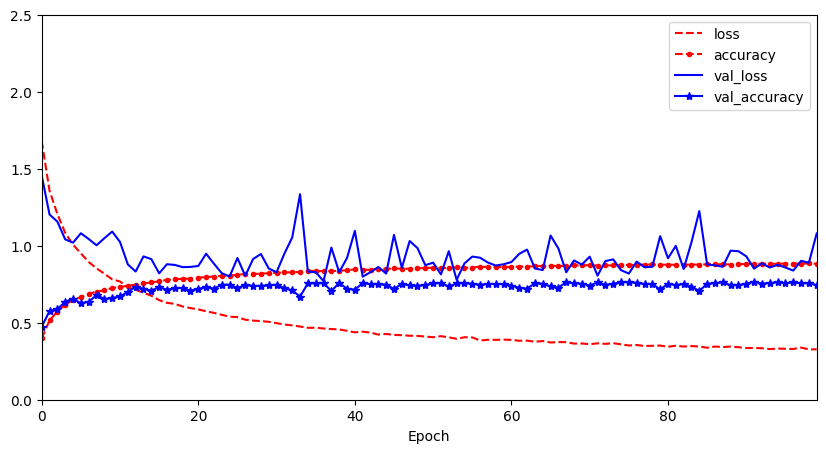

In [59]:
# Plot loss and accuracy versus epoch
pd.DataFrame(history.history).plot(figsize=(10, 5), xlim=[0, 99], ylim=[0, 2], grid=False, xlabel="Epoch", style=["r--", "r--.", "b-", "b-*"])
plt.show()

In [60]:
test_loss, test_acc = model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 1.0716 - accuracy: 0.7355


In [61]:
y_proba = model.predict(X_test)
y_proba.round(2)

313/313 [==============================] - 1s 2ms/step


array([[0.  , 0.  , 0.  , ..., 0.  , 0.01, 0.  ],
       [0.  , 0.02, 0.  , ..., 0.  , 0.98, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.99, 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 1.  , 0.  , 0.  ]], dtype=float32)

In [62]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([3, 8, 8, ..., 5, 4, 7], dtype=int64)

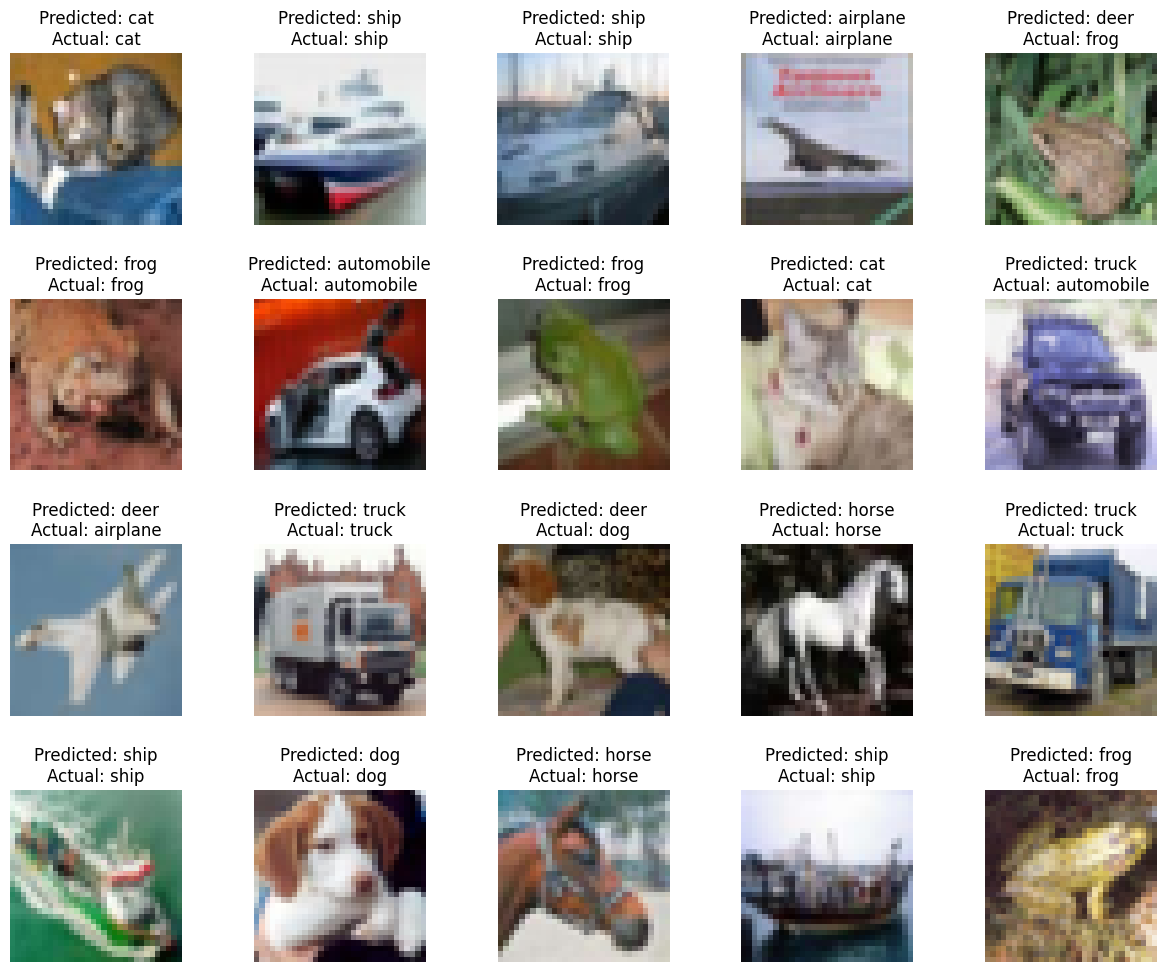

In [63]:
# Print images and predicted labels
num_images = 20
plt.figure(figsize=(15, 15))
for i in range(num_images):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_test[i])
    predicted_label = class_names[y_pred[i]]
    actual_label = class_names[y_test[i][0]]
    plt.title("Predicted: {}\nActual: {}".format(predicted_label, actual_label))
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=0.43)
plt.show()

In [64]:
# Calculate the accuracy, precision, and recall for the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

# Convert the scores to percentages
accuracy_pct = accuracy * 100
precision_pct = precision * 100
recall_pct = recall * 100

# Print the accuracy, precision, and recall for the test set as percentages
print("Test accuracy: {:.2f}%".format(accuracy_pct))
print("Test precision: {:.2f}%".format(precision_pct))
print("Test recall: {:.2f}%".format(recall_pct))

Test accuracy: 73.55%
Test precision: 73.85%
Test recall: 73.55%


In [65]:
# Calculate and print the precision and recall by class_id on the test set
target_names = [f"Class {i} ({class_names[i]})" for i in range(len(class_names))]
report = classification_report(y_test, y_pred, target_names=target_names)
print(report)

                      precision    recall  f1-score   support

  Class 0 (airplane)       0.79      0.76      0.77      1000
Class 1 (automobile)       0.87      0.84      0.86      1000
      Class 2 (bird)       0.66      0.65      0.65      1000
       Class 3 (cat)       0.60      0.45      0.51      1000
      Class 4 (deer)       0.64      0.77      0.70      1000
       Class 5 (dog)       0.73      0.50      0.60      1000
      Class 6 (frog)       0.64      0.92      0.75      1000
     Class 7 (horse)       0.81      0.80      0.80      1000
      Class 8 (ship)       0.82      0.86      0.84      1000
     Class 9 (truck)       0.84      0.83      0.83      1000

            accuracy                           0.74     10000
           macro avg       0.74      0.74      0.73     10000
        weighted avg       0.74      0.74      0.73     10000

